In [28]:
# Load the tensorflow
# import other necessary libraries

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time
import functools

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing import image as kp_image
from keras import models
from keras import backend as K
from keras.applications.vgg19 import VGG19

#tf.enable_eager_execution()
tf.executing_eagerly()
#print("Eager function: {}".format(tf.executing_eagerly))

True

In [29]:
# load the images
# content_path = input("Enter the path of content image: ")
#
# style_path = input("Enter the path of style image: ")

content_path = '/Users/chenzhuo/Desktop/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/Users/chenzhuo/Desktop/The_Great_Wave_off_Kanagawa.jpg'

In [30]:
# Define the load_img function
def load_img(path_to_img):
    max_dim = 512
    #img = PIL.Image.open(path_to_img)
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img = kp_image.img_to_array(img)

    img = np.expand_dims(img, axis=0)

    return img


In [31]:
def imshow(img, title = None):
    out = np.squeeze(img, axis = 0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

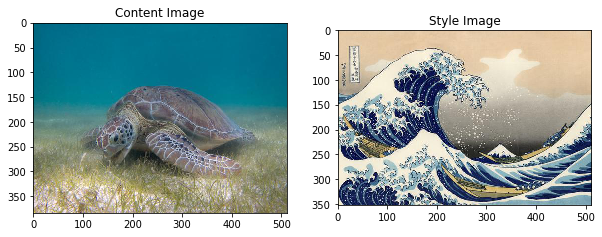

In [32]:
plt.figure(figsize= (10, 10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1,2,1)
imshow(content, 'Content Image')

plt.subplot(1,2,2,)
imshow(style, 'Style Image')

# Define content and style representation
def process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                               "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # Inverse the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    # [103.939, 116.779, 123.68] is the mean of channel values trained with vgg19
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Define the block layers

content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [33]:
# Build the model

def new_model():
    #vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs #Blend the two

    return models.Model(vgg.input, model_outputs)

# Define the loss function

def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Style loss
def gram_matrix(input):
    channels = int(input.shape[-1])
    a = tf.reshape(input, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram/tf.cast(n, tf.float32)

def style_loss(base_style, gram_target):
    height,width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))
    # The formula is (4. * (channel ** 2) * (width * height) ** 2)


In [34]:
# Gradient Descent
def feature_representation(model, content_path, style_path):
    content_image = process_img(content_path)
    style_image = process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

    return style_features, content_features

# Compute loss and gradients

def loss_computer(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 /float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss, style_score, content_score

def grads_computer(cfg):
    with tf.GradientTape() as tape:
        all_loss = loss_computer(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

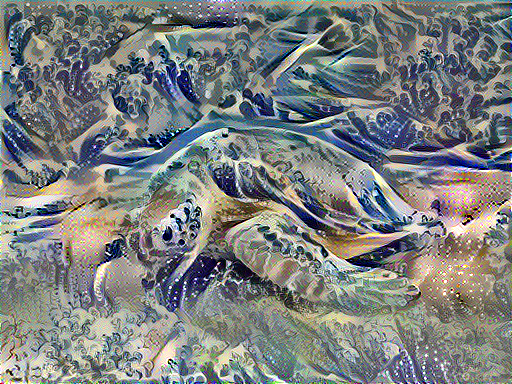

Iteration: 900
Total loss: 1.3504e+06, style loss: 7.1829e+05, content loss: 6.3215e+05, time: 0.0864s
Total time: 3642.3232s


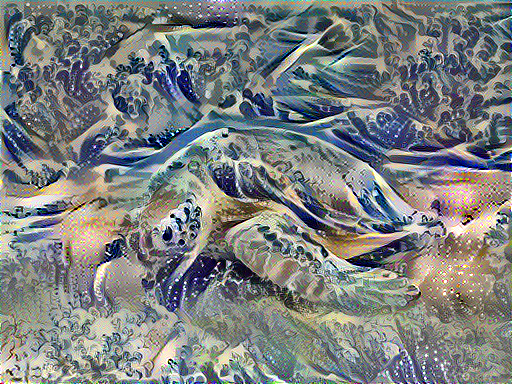

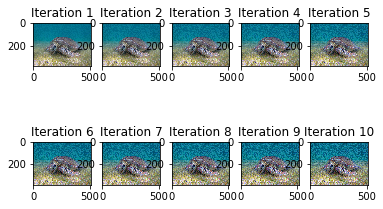

In [35]:
# Optimizing the loop
import IPython.display

def ast(content_path, style_path, num_iterations = 1000, content_weight = 1000, style_weight = 0.01):
    display_num = 100
    model = new_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = feature_representation(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = process_img(content_path)
    init_image = tf.Variable(init_image, dtype = tf.float32)

    opt = tf.optimizers.Adam(learning_rate = 5, beta_1 = 0.99, epsilon = 0.1)

    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)

    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    # Display
    # num_rows = 2
    # num_cols = 5
    num_rows = (num_iterations / display_num) // 5


    #display_interval = num_iterations/(num_rows* num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []

    for i in range(num_iterations):
        grads, all_loss = grads_computer(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

        if loss< best_loss:
            best_loss = loss
            best_img = deprocess(init_image.numpy())

        if i % display_num == 0:
            start_time = time.time()

            plot_img = init_image.numpy()
            plot_img = deprocess(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait= True)
            IPython.display.display_png(PIL.Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))

        if iter_count > num_rows * 5: continue
        plt.subplot(num_rows, 5, iter_count)
        plot_img = init_image.numpy()
        plot_img = deprocess(plot_img)
        plt.imshow(plot_img)
        plt.title('Iteration {}'.format(i+1))
        iter_count += 1

    print('Total time: {:.4f}s'.format(time.time() - global_start))
        # IPython.display.clear_output(wait= True)
        # plt.figure(figsize= (14,4))
        # for i, img in enumerate(imgs):
        #     plt.subplot(num_rows, num_cols, i+1)
        #     plt.imshow(img)
        #     plt.xticks([])
        #     plt.yticks([])

    return best_img, best_loss


best, best_loss = ast(content_path, style_path, num_iterations=1000)

PIL.Image.fromarray(best)

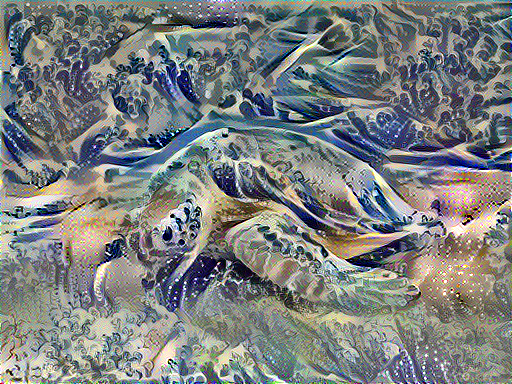

Iteration: 900
Total loss: 1.3504e+06, style loss: 7.1829e+05, content loss: 6.3215e+05, time: 0.0786s
Total time: 3407.2771s


ValueError: invalid literal for int() with base 10: '/Users/chenzhuo/Desktop/Green_Sea_Turtle_grazing_seagrass.jpg'

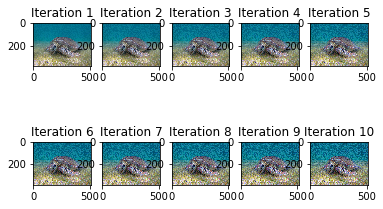

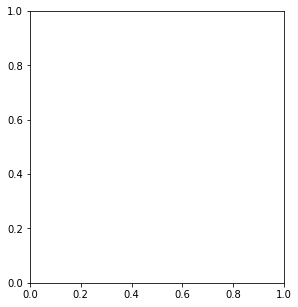

In [36]:
def results(bes_img, content_path, style_path, show_large_final = True):
    plt.figure(figsize= (10, 5))
    content = load_img(content_path)
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content_path, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final:
        plt.figure(figsize= (10, 10))

        plt.imshow(bes_img)
        plt.title('Output Image')
        plt.show()


# Test the model and get results
# Example
best, best_loss = ast(content_path, style_path)
results(best, content_path, style_path)

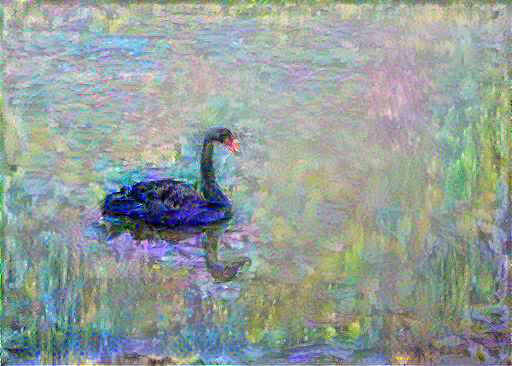

Iteration: 900
Total loss: 2.1566e+05, style loss: 9.2177e+04, content loss: 1.2349e+05, time: 0.0777s
Total time: 3346.7765s


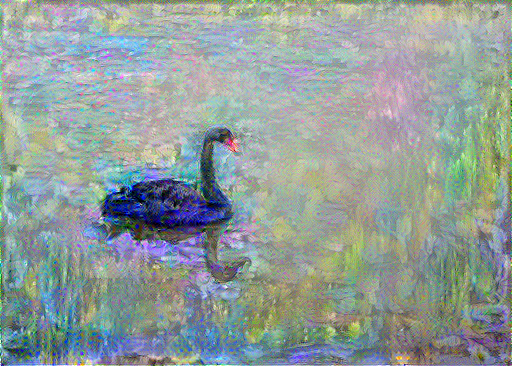

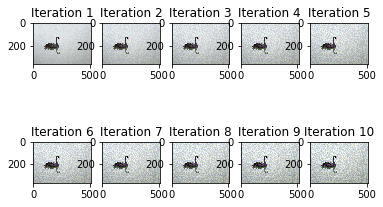

In [37]:
# Generate a new one
new_content = '/Users/chenzhuo/Desktop/black-swan.JPG'
new_style = '/Users/chenzhuo/Desktop/MonetLotus.jpg'

best, best_loss = ast(new_content, new_style, num_iterations=1000)

PIL.Image.fromarray(best)